# Measuring the Gender Pay Gap with Blinder-Oaxaca Decompositions
---------
#### Chris Fong and Ronald Walker

Due May 9th at 5pm

Requirements:

1. It should involve the use of real data to explore a question of interest to you.

2. The data should be analyzed using figures/maps, summary tables as well as statistical methods introduced in Ec 140, 141 or C142. As a rough guide a good project will include 2-3 figures, 2-3 displays of summary or descriptive statistics (e.g., cross-tabs) and the presentation of estimation results from a small collection of econometric models (e.g., OLS or quantile regression fits with different conditioning variables).

3. The analysis and write-up should be done in Python using a Jupyter notebook (with all project narrative included in markdown cells). Code should be clearly commented. The write-up should explain the assumptions being invoked to justify the analysis and also include a discussion and interpretation of any results. A clear discussion of the limitations of the analysis and how it might be improved through further work should also be included.

4. group projects need to include a few paragraphs explaining each team members specific contributions

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import numpy as np
%matplotlib inline

0 -- Background

1 -- Implementation and Interpretation of Blinder-Oaxaca

2 -- Data Collection and Cleaning

3 -- Application of Blinder-Oaxaca

## 0. Background / Introduction

Motivation -- may merge w/ 1.

Relating to previous studies. Seeing how this measures up compared to other measures.

## 1. Implementation and Interpretation of Blinder-Oaxaca

Blinder-Oaxaca decompositions are easily performed in Stata with the `oaxaca` package. There is also an R package, but there is yet to be one created for Python. This project is the underlying foundation for a Python implementation.

The goal of a Blinder-Oaxaca decomposition is to take the difference in expected outcomes between two groups, and identify what contributes to the outcome gap. 

#### Decompositions

*Note: Because the scope of this project is to create a greater understanding of the root of potential pay gaps, this walkthrough will be in the context of that. Our outcome of interest will be wages $w$. The two groups we will be comparing will be males $m$ and females $f$.*

In this section we'll break down the calculation of the decomposition. The wage gap in wages is the difference in the average wage for males and the average wage for females.

$$Gap = E[Wage_m] - E[Wage_f]$$

We will substitute those expectations with a linear model for each group using the following form, where $X$ are the attributes that go into determining an individual's wage, and $\epsilon$ is an error term:

$$Wage= X'\beta + \epsilon$$

where $\bar\epsilon=0$. After plugging the linear models for each gender into the $Gap$ equation, and using the assumption that the expectation of the errors is zero and making the assumption that $E[\beta]=\beta$, we are left with

$$Gap = E[X_m]'\beta_m - E[X_f]'\beta_f$$

We can further decompose the regression terms and $X$ values to identify the source of the difference. There are two main ways that Oaxaca-type decompositions are broken down.

###### 1. Three-fold

$$Gap = (E[X_m]-E[X_f])'\beta_f \quad \quad (1)$$
$$+E[X_f]'(\beta_m-\beta_f) \quad \quad \quad (2)$$
$$+(E[X_m]-E[X_f])'(\beta_m-\beta_f) \quad \quad (3)$$

Each of those represents a source of the difference.

(1) Endowments

(2) Coefficients

(3) Interactions

{whose perspective is this from}

We are able to break each of those up into their subfactors (for each variable) by summing

So for example, for each of the $m$ variables, 

$$(E[X_m]-E[X_f])'\beta_f = \sum_{i=1}^{m}(E[X_{mi}]-E[X_{fi}])'\beta_{fi}$$

###### 1. Two-fold

$$Gap = $$

Unexplained / Explained

#### Calculating Standard Errors

We are building on top of `statsmodels`, so the framework will easily translate to regression models outside of just OLS.

## 2. Data

Where the data set is from.

How we plan to use it.

Any standardization and cleaning you did.

Any caveats.

Summary tables and statistics.

In [8]:
data = pd.read_csv('Brazil.csv')
print(data.shape)
data.head()

(5300079, 9)


,COUNTRY,PERWT,AGE,SEX,MARST,NATIVITY,EDATTAIN,EMPSTAT,INCTOT
0,Brazil,18.54,22,1,2,1,2,1,1000.0
1,Brazil,20.23,54,1,2,1,1,1,700.0
2,Brazil,20.23,44,2,2,1,1,1,419.0
3,Brazil,20.23,22,2,1,1,1,3,510.0
4,Brazil,20.23,26,2,1,1,3,1,650.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1193b97f0>]], dtype=object)

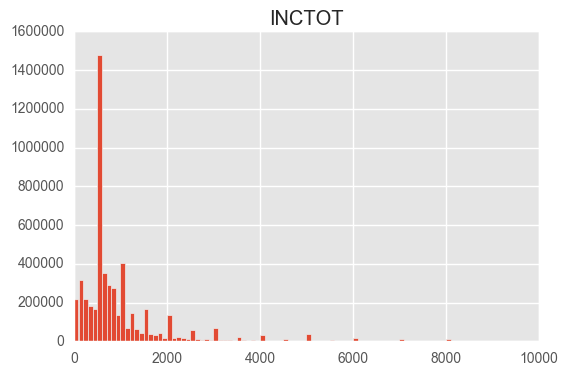

In [26]:
data.hist('INCTOT', bins=np.arange(0,10000, 100))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1171ad208>]], dtype=object)

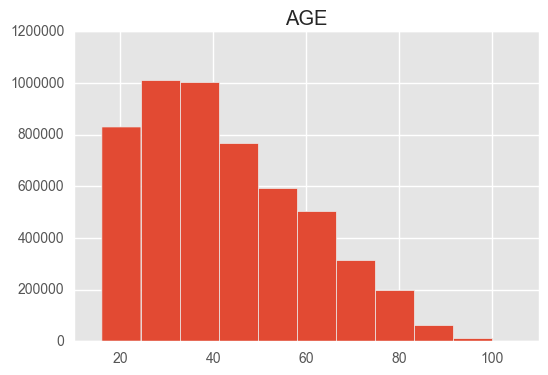

In [21]:
data.hist('AGE')

## 3. Application

For each country of interest:

Find current measure of pay gap inequality.

Regress log(wages) on gender and other variables (race, number of dependents, education, etc.) and control for role/industry, industry, neither.

Plot stacked bar chart of explained + unexplained.

Plot current measure of inequality vs unexplained proportion from B-O.

**Citations:**

Jann, Ben, 2008. "<a href="https://EconPapers.repec.org/RePEc:ets:wpaper:5">A Stata implementation of the Blinder-Oaxaca decomposition</a>", No 5, ETH Zurich Sociology Working Papers, ETH Zurich, Chair of Sociology.

__our data source__

Kennedy, Peter & Jutta Heinrichs, 2007. "A computational trick for calculating the Blinder-Oaxaca decomposition and its standard error," Economics Bulletin, AccessEcon, vol. 3(66), pages 1-7.